# Exploiting brazilian e-commerce data

This project aims to understand how did e-commerce behaviored in Brazil between 2016 and 2018, exploiting categories, top products and other insights.

A few b-questions to answer looking at this data is:
- What is top 5 categories? - OK
- When did most of the purchases happen? - OK
- What time of the day people used to buy more? - OK
- What seems to be the customers profiles identifiable? (pop this one out of the list)
- Average tickets;
- What region has the highest average ticket?
- What region shows a highest orders tred? This may be interesting for logistics considerations; 
- Create a heatmap with the average ticket information, by region.

The data contained in this project was last retrieved from [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) public repository, by January 14th, 2023.

In [1]:
# loading PEP8 codesytle to make sure code is more readable

%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on
%pycodestyle_off

In [3]:
# importing needed libraries

import pandas as pd
import warnings
#warnings.filterwarnings("ignore")

from datetime import datetime as dt
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
fontfamily = 'serif'
rcParams['font.family'] = fontfamily
rcParams['font.sans-serif'] = ['Tahoma']

# Possible fonts = Tahoma, DejaVu Sans, Lucida Grande, Verdana

In [4]:
# setting the path to all data 

data_path = "data/"

In [5]:
# reading all interesting data files
orders_file = "olist_orders_dataset.csv"
items_file = "olist_order_items_dataset.csv"
products_file = "olist_products_dataset.csv"
customers_file = "olist_customers_dataset.csv"
translation_file = "product_category_name_translation.csv"
geolocation_file = "'olist_geolocation_dataset.csv'"

orders = pd.read_csv(os.path.join(data_path, orders_file))
items = pd.read_csv(os.path.join(data_path, items_file))
products = pd.read_csv(os.path.join(data_path, products_file))
translation = pd.read_csv(os.path.join(data_path, translation_file))
customers = pd.read_csv(os.path.join(data_path, customers_file))
cat_trans = pd.read_csv(os.path.join(data_path, translation_file))
geolocat = pd.read_csv(os.path.join(data_path, customers_file))

Lets explore the datasets we have

### Customers

In [6]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Orders

In [7]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


So what do we have? A 8 columns data set with only orders' data such as:
- a unique ID;
- a unique ID for the one who purchased;
- status of the order
- the moment it was purchased;
- the moment the purchase was approved;
- the moment it was delivered to the carrier;
- the exact moment the customer received it's purchase;
- the expected delivery moment.

Nice. That will give us already a lot to exploit.

Doing some feature engineering we can further see other information that are only subliminar so far, such as the weekday the purchase was made and difference between expected delivery time and real delivery time. Let's get this!

First, let's make sure every column that suggets a timestamp data type is ok

In [8]:
timestamp_like_columns = ['order_purchase_timestamp', 'order_approved_at',
                          'order_delivered_carrier_date',
                          'order_delivered_customer_date',
                          'order_estimated_delivery_date']
for c in timestamp_like_columns:
    orders[c] = pd.to_datetime(orders[c])

Now lets finally get our new data

In [9]:
orders['purchase_weekday'] = orders['order_purchase_timestamp'].dt.day_name()
orders['purchase_date'] = orders['order_purchase_timestamp'].dt.date
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.month
orders['purchase_year'] = orders['order_purchase_timestamp'].dt.year
orders['days_diff'] = pd.Series(orders['order_delivered_customer_date'] -
                                orders['order_estimated_delivery_date']).dt.days  # nopep8 E501

In [10]:
black_fridays = [dt.strptime(d, "%d/%m/%Y") for d in ('24/11/2017', '23/11/2018')]  # nopep8

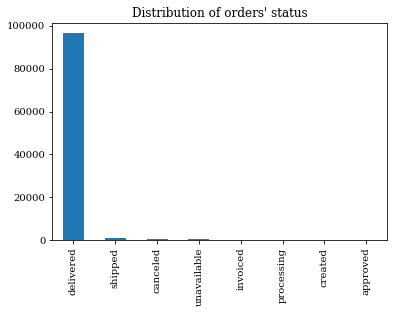

In [11]:
title = "Distribution of orders' status"
plot = orders.order_status\
            .value_counts()\
            .plot(kind="bar",
                  title=title)

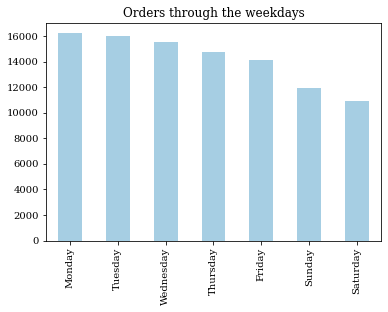

In [12]:
# selecting the column to analyse and then
# creating a value counts to check the frequency

title = "Orders through the weekdays"
plot = orders.purchase_weekday\
                .value_counts()\
                .plot(kind="bar",
                      title=title,
                      colormap="Paired")  # displaying a bar plot

Some notes to take here: 
- These customers are more likely to buy on weekday than on the weekend;
- There is not a lot of data about non-delivered orders.

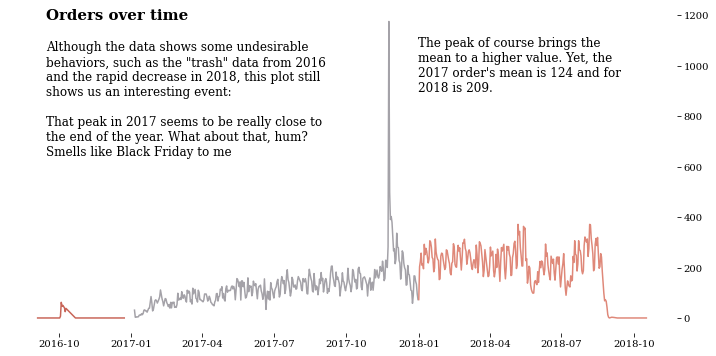

In [13]:
# setting the plot

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# setting different colors for each year with
# the grey to red palette
colors = ['#580F41', '#DDA0DD', '#9A0EEA'] #purple

colors = ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1",
          "#a4a2a8", "#df8879", "#c86558", "#b04238", "#991f17"]

# identifying the number of orders by day per year

average_orders = {}
years = orders.purchase_year.unique()

for i, year in enumerate(years):
    df = orders[orders.purchase_year == year]\
            .groupby(['purchase_date'])['order_id']\
            .count()
    average_orders[year] = int(df.mean())
    ax.plot(df.index, df, color=colors[i+4])

big_text = '''Although the data shows some undesirable
behaviors, such as the "trash" data from 2016 
and the rapid decrease in 2018, this plot still
shows us an interesting event:

That peak in 2017 seems to be really close to
the end of the year. What about that, hum? 
Smells like Black Friday to me
'''
title_text = 'Orders over time'
 
fig.text(0.17, 0.85, title_text, fontsize=15,
         fontweight='bold', fontfamily=fontfamily)
fig.text(0.17, 0.50, big_text, fontsize=12,
         fontweight='light', fontfamily=fontfamily)

bf_text = f'''
The peak of course brings the
mean to a higher value. Yet, the 
2017 order's mean is {average_orders[2017]} and for
2018 is {average_orders[2018]}.
'''
fig.text(0.60, 0.65, bf_text, fontweight="light",
         fontfamily=fontfamily, fontsize=12)

for s in ['top', 'right','bottom','left']:
     ax.spines[s].set_visible(False)
ax.yaxis.tick_right()
plt.show()

Looking at this information may be pointless, so let's explore other features of these datasets

### Items

In [14]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
print(F"The amount of order is {items.order_id.nunique()}")
print(F"The amount of order is {items.product_id.nunique()}")

The amount of order is 98666
The amount of order is 32951


So obviously there are repeated products ordered. Let's take a look on that behaviour

In [16]:
# these are top 10 orderes producs

top_10_items = items.product_id.value_counts()[:10]
print(top_10_items)
top_10_items = top_10_items.to_dict()

aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
53759a2ecddad2bb87a079a1f1519f73    373
d1c427060a0f73f6b889a5c7c61f2ac4    343
53b36df67ebb7c41585e8d54d6772e08    323
154e7e31ebfa092203795c972e5804a6    281
3dd2a17168ec895c781a9191c1e95ad7    274
Name: product_id, dtype: int64


In [17]:
# lets check the representativity of these guys

perc_orders = sum(top_10_items.values())/items.product_id.nunique()
perc_orders

0.11753816272647265

Well, out of 30k+ ordered produtcs in almost 100k registers, top 10 represent something close to 12% of the total requests. That's cool but let's say nothing more. For now.

And how long are the orders?

In [18]:
items.order_item_id.value_counts(normalize=True)

1     0.875863
2     0.087022
3     0.020302
4     0.008566
5     0.004083
6     0.002273
7     0.000515
8     0.000320
9     0.000249
10    0.000222
11    0.000151
12    0.000115
13    0.000071
14    0.000062
15    0.000044
16    0.000027
17    0.000027
18    0.000027
19    0.000027
20    0.000027
21    0.000009
Name: order_item_id, dtype: float64

We can see the orders oftenly (up to 96%) had the maximum of 2 items. And the one with the highest number of itens, had 21 of them! 

Let's see some other general stats about the items' prices, the orders's prices and their freights.

In [19]:
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


By the descriptive statistics of price and freight value, we can se the average order's price is about 120 reais with a high standard deviation and a real high max value (about 60 times). About the freight, it is 19 reais, with a not-that-high standard deviation and maximum value that is 20 times higher than the mean. Cool! What if we try to investigate these features in a closer look.

Looking at the summary provided by the .describe() method, we'll see that about 75% of the order's prices are below 134.9 reais and for the freight value, the number we are observing is 21.15. Considering these data, with a widespread distribution, it may be a good value to cut our data and analise the lower cut for a histogram look. Let's see how this goes.

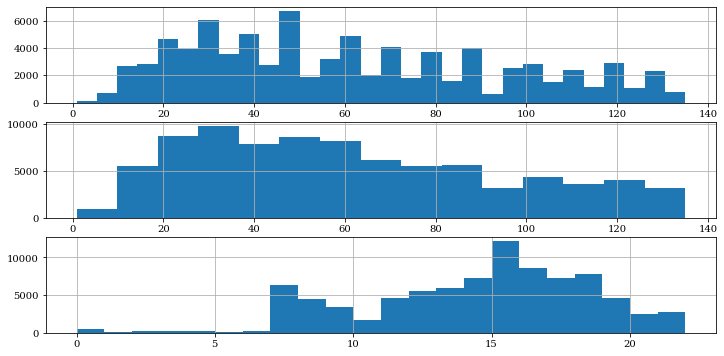

In [20]:
# creating our matpplotlib figure 

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

# plotting the histograms of each column
items[items['price'] <= 135]\
     .price.hist(bins=30, ax = ax1)
items[items['price'] <= 135]\
     .price.hist(bins=15, ax = ax2)
items[items['freight_value'] <= 22]\
     .freight_value.hist(bins=22, ax = ax3)

plt.show();

It is interesting how the 15 and 30 bins are so different. When we look at the 30 bins histogram we can see that there is a trend for the prices value to group around "round values" such as the 10 multiples. We couldn't see this just with the 15 bins histogram. Nice! Still, is there any value in this information? Not until now. Let's keep on going!

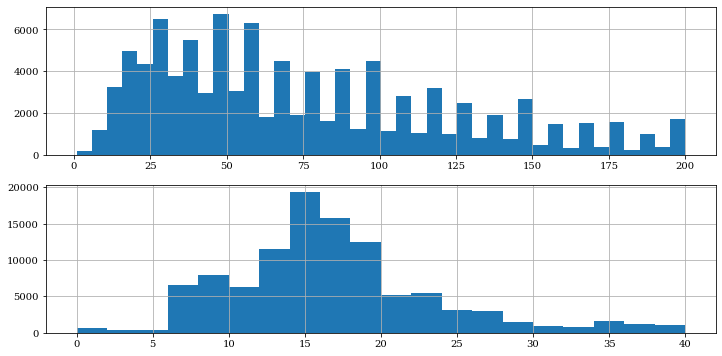

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plotting the histograms of each column
items[items['price'] <= 200]\
     .price.hist(bins=40, ax = ax1)
items[items['freight_value'] <= 40]\
     .freight_value.hist(bins=20, ax = ax2)

plt.show();

In [22]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Ok, so now we can see at least 3 columns that may be interesting for us. They are "product_id", "product_category_name" and "product_photos_qty". And why is the last one in the list? I have a feeling that the higher the number of photos, the easier it is to sell the product. We can check this a bit later.

With all the datasets we have, we can create a new one with all the information we now consider to be important. Le's try this out.

In [23]:
# columns to filter out of the products dataset
list_of_columns_prod = ['product_id', 'product_category_name', 'product_photos_qty']

In [24]:
full_orders = orders.merge(items,
                           how='inner',
                           on='order_id')\
                    .merge(products[list_of_columns_prod],
                           how='inner',
                           on='product_id')\
                    .merge(cat_trans,
                           how='inner',
                           on="product_category_name")

# cleaning up some columns that are no needed

unecessary_columns = ['order_status', 'seller_id']
full_orders.drop(columns=unecessary_columns,
                 inplace=True)


In [25]:
full_orders.head(2)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_weekday,purchase_date,purchase_month,purchase_year,days_diff,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name,product_photos_qty,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,Monday,2017-10-02,10,2017,-8.0,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,4.0,housewares
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,Tuesday,2017-08-15,8,2017,-10.0,1,87285b34884572647811a353c7ac498a,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,4.0,housewares


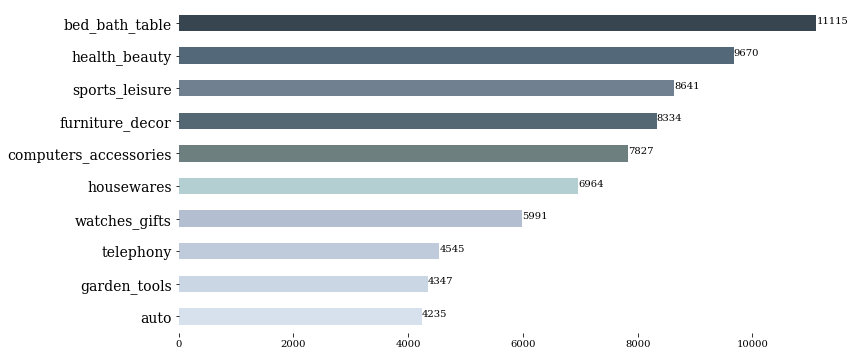

In [26]:
# plot top 10 ordered categories

# setting the plot

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# setting different colors for each category
# the grey to grey blue palette
colors = ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1", "#b3cfd1",
          "#6e7f80", "#536872", "#708090", "#536878", "#36454f"]
colors = colors[::-1]

top_10_categories = full_orders.product_category_name_english.value_counts().head(10)


ax = top_10_categories.plot(kind='barh', color=colors)
ax.invert_yaxis()
ax.yaxis.set_tick_params(labelsize=14)

for i, v in enumerate(top_10_categories):
    plt.text(v, i, str(v), fontsize=10)

for s in ['top', 'right','bottom','left']:
     ax.spines[s].set_visible(False)

plt.show()

In [27]:
full_orders.product_category_name.value_counts()

cama_mesa_banho                  11115
beleza_saude                      9670
esporte_lazer                     8641
moveis_decoracao                  8334
informatica_acessorios            7827
                                 ...  
artes_e_artesanato                  24
la_cuisine                          14
cds_dvds_musicais                   14
fashion_roupa_infanto_juvenil        8
seguros_e_servicos                   2
Name: product_category_name, Length: 71, dtype: int64

In [28]:
full_orders.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_weekday,purchase_date,purchase_month,purchase_year,days_diff,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name,product_photos_qty,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,Monday,2017-10-02,10,2017,-8.0,1,87285b34884572647811a353c7ac498a,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,4.0,housewares
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,Tuesday,2017-08-15,8,2017,-10.0,1,87285b34884572647811a353c7ac498a,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,4.0,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,Wednesday,2017-08-02,8,2017,-8.0,1,87285b34884572647811a353c7ac498a,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,4.0,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,Monday,2017-10-23,10,2017,-6.0,1,87285b34884572647811a353c7ac498a,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,4.0,housewares
4,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,Friday,2017-11-24,11,2017,7.0,1,be021417a6acb56b9b50d3fd2714baa8,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,6.0,housewares
